# Train Blending (BERT cased, DistilBERT uncased, DeBERTa)

Best F1 score BERT model on HS_C dataset are used

In [1]:
# This automates data tabulation onto google sheets 

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis'

# Change the current working directory
os.chdir(new_directory)

# Use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('thesis-432315-12daec8d1ff6.json', scope)

service = build('sheets', 'v4', credentials=creds)

client = gspread.authorize(creds)

spreadsheet_id = '13Fk5oXX9B_mdHmNpMKQMy29y9iiHWrgQCa4hUTiQKD0' 

## Load Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score


import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis/Development'

# Change the current working directory
os.chdir(new_directory)

# Adjust file paths to local system
file_path = 'Corpus/FiReCS/FiReCS_data_b.csv'
df = pd.read_csv(file_path)

# Split the data
holdout_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

## Load Models and Tokenizers

In [3]:
def load_model_and_tokenizer(model_path, tokenizer_path, base_model):
    # Load the tokenizer from the local directory
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Load the configuration from the base model
    config = AutoConfig.from_pretrained(base_model, num_labels=3)

    # Initialize the model with the configuration
    model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

    # Ensure the model is in evaluation mode
    model.eval()
    
    return model, tokenizer

model_info = {

    'DistilBERT cased': {
        'model_path': 'BERT models/1 FiReCS/fire_distilbert-base-cased-finetuned',
        'tokenizer_path': 'BERT models/1 FiReCS/fire_distilbert-base-cased-finetuned',
        'base_model': 'distilbert/distilbert-base-cased'
    },

    'DeBERTa': {
        'model_path': 'BERT models/1 FiReCS/fire_DeBERTa-finetuned',
        'tokenizer_path': 'BERT models/1 FiReCS/fire_DeBERTa-finetuned',
        'base_model': 'microsoft/deberta-v3-base'
    },

    'HateBERT': {
        'model_path': 'BERT models/1 FiReCS/fire_HateBERT-finetuned',
        'tokenizer_path': 'BERT models/1 FiReCS/fire_HateBERT-finetuned',
        'base_model': 'GroNLP/hateBERT'
    },

}

models_and_tokenizers = {name: load_model_and_tokenizer(info['model_path'], 
                                                        info['tokenizer_path'], 
                                                        info['base_model']) 
                         for name, info in model_info.items()}

## Apply Tokenization

In [4]:
def texts_to_dataloader(texts, tokenizer, batch_size=32):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

## Perform Blending

In [5]:
%load_ext memory_profiler

In [6]:
%%memit

def get_meta_features(model, tokenizer, df, device):
    texts = df['review'].tolist()
    dataloader = texts_to_dataloader(texts, tokenizer, batch_size=32)
    
    model.to(device)
    model.eval()
    meta_features = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            meta_features.append(probs.cpu().numpy())
    return np.concatenate(meta_features)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Generate meta-features for holdout and test sets
holdout_meta_features = [get_meta_features(model, tokenizer, holdout_df, device) for model, tokenizer in models_and_tokenizers.values()]
test_meta_features = [get_meta_features(model, tokenizer, test_df, device) for model, tokenizer in models_and_tokenizers.values()]

# Stack meta-features
holdout_meta_features = np.hstack(holdout_meta_features)
test_meta_features = np.hstack(test_meta_features)

peak memory: 2237.64 MiB, increment: 332.30 MiB


In [7]:
# Check the base model predictions
for name, (model, tokenizer) in models_and_tokenizers.items():
    print(f"Checking base model predictions for {name}...")
    base_model_preds = get_meta_features(model, tokenizer, test_df, device)
    print("Predictions distribution:", np.mean(base_model_preds, axis=0))

Checking base model predictions for DistilBERT cased...
Predictions distribution: [0.3628004  0.27689946 0.36030024]
Checking base model predictions for DeBERTa...
Predictions distribution: [0.33203426 0.3266011  0.34136456]
Checking base model predictions for HateBERT...
Predictions distribution: [0.29686573 0.38674074 0.31639358]


### Train LR

In [8]:
%%memit
# Train the LR meta-classifier
lr_meta_classifier = LogisticRegression()
lr_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2247.50 MiB, increment: 0.72 MiB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Train NB

In [9]:
%%memit
# Train the NB meta-classifier
nb_meta_classifier = GaussianNB()
nb_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2247.52 MiB, increment: 0.00 MiB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Train DT

In [10]:
%%memit
# Train the DT meta-classifier
dt_meta_classifier = DecisionTreeClassifier(max_depth=None)  
dt_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2247.70 MiB, increment: 0.19 MiB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Train SVM

In [11]:
%%memit
# Train the SVM meta-classifier
svm_meta_classifier = SVC(kernel='linear', probability=True)
svm_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2259.38 MiB, increment: 11.67 MiB


## Evaluate Models

### LR

In [12]:
lr_final_predictions = lr_meta_classifier.predict(test_meta_features)

# Evaluate
precision = precision_score(test_df['label'].values, lr_final_predictions, average='macro')
recall = recall_score(test_df['label'].values, lr_final_predictions, average='macro')
accuracy = accuracy_score(test_df['label'].values, lr_final_predictions)
f1 = f1_score(test_df['label'].values, lr_final_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, lr_final_predictions)

print("Logistic Regression")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Logistic Regression
Precision: 0.8158
Recall: 0.8146
Ensemble accuracy: 0.8129
F1 Score: 0.8152
Confusion Matrix:
[[393  80   2]
 [ 76 366  49]
 [  5  53 392]]


In [13]:
probabilities = lr_meta_classifier.predict_proba(test_meta_features)

# Calculate precision-recall curve and find optimal thresholds for each class
lr_thresh = []
for i in range(probabilities.shape[1]):  # Iterate over each class
    precision, recall, thresholds = precision_recall_curve(test_df['label'].values == i, probabilities[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)  # Handle cases where precision and recall are both zero
    lr_thresh.append(thresholds[optimal_idx])

# Apply the optimized thresholds to make adjusted predictions
adjusted_predictions = np.array([np.argmax([probabilities[i, j] if probabilities[i, j] >= lr_thresh[j] else 0
                                         for j in range(probabilities.shape[1])])
                              for i in range(len(probabilities))])

# Evaluate
adjusted_precision = precision_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_recall = recall_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_accuracy = accuracy_score(test_df['label'].values, adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'].values, adjusted_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, adjusted_predictions)

print("Optimized thresholds for each class:", lr_thresh)
print("Logistic Regression")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Ensemble accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(conf_matrix)

Optimized thresholds for each class: [0.3061792777540618, 0.4233466171060535, 0.36435755717488044]
Logistic Regression
Precision: 0.8159
Recall: 0.8146
Ensemble accuracy: 0.8129
F1 Score: 0.8152287090875715
Confusion Matrix:
[[393  80   2]
 [ 77 366  48]
 [  5  53 392]]


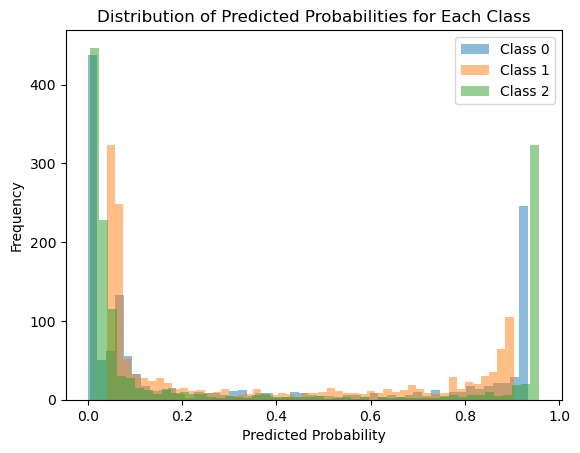

In [14]:
import matplotlib.pyplot as plt

for i in range(probabilities.shape[1]):  # For each class
    plt.hist(probabilities[:, i], bins=50, alpha=0.5, label=f'Class {i}')
plt.title('Distribution of Predicted Probabilities for Each Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [15]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!B8:E8'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### NB

In [16]:
nb_final_predictions = nb_meta_classifier.predict(test_meta_features)

# Evaluate
precision = precision_score(test_df['label'].values, nb_final_predictions, average='macro')
recall = recall_score(test_df['label'].values, nb_final_predictions, average='macro')
accuracy = accuracy_score(test_df['label'].values, nb_final_predictions)
f1 = f1_score(test_df['label'].values, nb_final_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, nb_final_predictions)

print("Naive Bayes")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Naive Bayes
Precision: 0.8123
Recall: 0.8120633786321427
Ensemble accuracy: 0.8100
F1 Score: 0.8122
Confusion Matrix:
[[394  79   2]
 [ 82 359  50]
 [  4  52 394]]


In [17]:
probabilities = nb_meta_classifier.predict_proba(test_meta_features)

# Calculate precision-recall curve and find optimal thresholds for each class
nb_thresh = []
for i in range(probabilities.shape[1]):  # Iterate over each class
    precision, recall, thresholds = precision_recall_curve(test_df['label'].values == i, probabilities[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)  # Handle cases where precision and recall are both zero
    nb_thresh.append(thresholds[optimal_idx])

# Apply the optimized thresholds to make adjusted predictions
adjusted_predictions = np.array([np.argmax([probabilities[i, j] if probabilities[i, j] >= nb_thresh[j] else 0
                                         for j in range(probabilities.shape[1])])
                              for i in range(len(probabilities))])

# Evaluate
adjusted_precision = precision_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_recall = recall_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_accuracy = accuracy_score(test_df['label'].values, adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'].values, adjusted_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, adjusted_predictions)

print("Optimized thresholds for each class:", nb_thresh)
print("Naive Bayes")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Ensemble accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(conf_matrix)

Optimized thresholds for each class: [0.05155373772342503, 0.003354621735239388, 0.9410272400870007]
Naive Bayes
Precision: 0.8165
Recall: 0.8146
Ensemble accuracy: 0.8129
F1 Score: 0.8154657435615459
Confusion Matrix:
[[394  79   2]
 [ 82 366  43]
 [  4  55 391]]


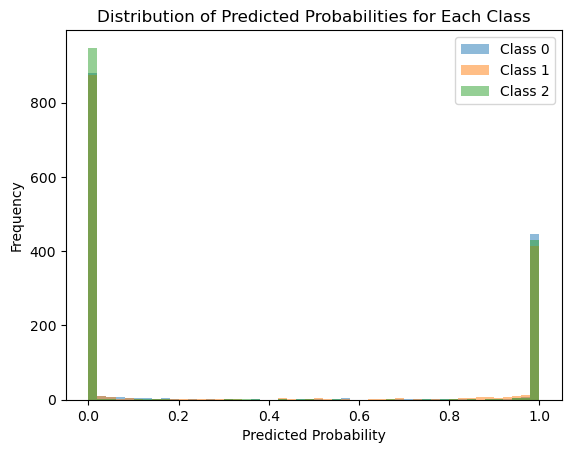

In [18]:
import matplotlib.pyplot as plt

for i in range(probabilities.shape[1]):  # For each class
    plt.hist(probabilities[:, i], bins=50, alpha=0.5, label=f'Class {i}')
plt.title('Distribution of Predicted Probabilities for Each Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [19]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!B9:E9'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### DT

In [20]:
dt_final_predictions = dt_meta_classifier.predict(test_meta_features)

# Evaluate
precision = precision_score(test_df['label'].values, dt_final_predictions, average='macro')
recall = recall_score(test_df['label'].values, dt_final_predictions, average='macro')
accuracy = accuracy_score(test_df['label'].values, dt_final_predictions)
f1 = f1_score(test_df['label'].values, dt_final_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, dt_final_predictions)

print("Decision Tree")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Decision Tree
Precision: 0.7491
Recall: 0.7492
Ensemble accuracy: 0.7465
F1 Score: 0.7489
Confusion Matrix:
[[351 112  12]
 [ 94 325  72]
 [  7  62 381]]


In [21]:
probabilities = dt_meta_classifier.predict_proba(test_meta_features)

# Calculate precision-recall curve and find optimal thresholds for each class
dt_thresh = []
for i in range(probabilities.shape[1]):  # Iterate over each class
    precision, recall, thresholds = precision_recall_curve(test_df['label'].values == i, probabilities[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)  # Handle cases where precision and recall are both zero
    dt_thresh.append(thresholds[optimal_idx])

# Apply the optimized thresholds to make adjusted predictions
adjusted_predictions = np.array([np.argmax([probabilities[i, j] if probabilities[i, j] >= dt_thresh[j] else 0
                                         for j in range(probabilities.shape[1])])
                              for i in range(len(probabilities))])

# Evaluate
adjusted_precision = precision_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_recall = recall_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_accuracy = accuracy_score(test_df['label'].values, adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'].values, adjusted_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, adjusted_predictions)

print("Optimized thresholds for each class:", dt_thresh)
print("Decision Tree")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Ensemble accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(conf_matrix)

Optimized thresholds for each class: [1.0, 1.0, 1.0]
Decision Tree
Precision: 0.7491
Recall: 0.7492
Ensemble accuracy: 0.7465
F1 Score: 0.7488780317365388
Confusion Matrix:
[[351 112  12]
 [ 94 325  72]
 [  7  62 381]]


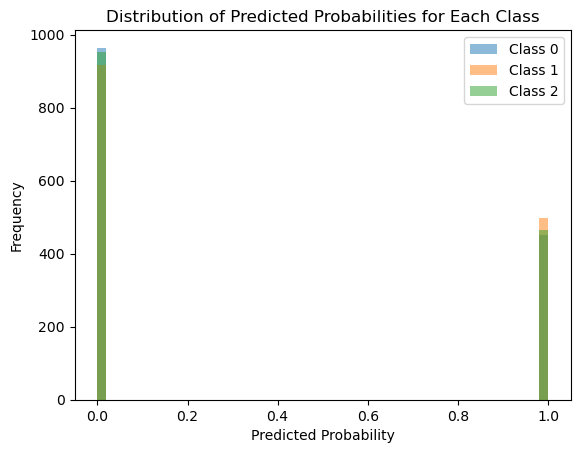

In [22]:
import matplotlib.pyplot as plt

for i in range(probabilities.shape[1]):  # For each class
    plt.hist(probabilities[:, i], bins=50, alpha=0.5, label=f'Class {i}')
plt.title('Distribution of Predicted Probabilities for Each Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [23]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!B10:E10'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### SVM

In [24]:
svm_final_predictions = svm_meta_classifier.predict(test_meta_features)

# Evaluate
precision = precision_score(test_df['label'].values, svm_final_predictions, average='macro')
recall = recall_score(test_df['label'].values, svm_final_predictions, average='macro')
accuracy = accuracy_score(test_df['label'].values, svm_final_predictions)
f1 = f1_score(test_df['label'].values, svm_final_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, svm_final_predictions)

print("SVM")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

SVM
Precision: 0.8210
Recall: 0.8195
Ensemble accuracy: 0.8178
F1 Score: 0.8202
Confusion Matrix:
[[396  77   2]
 [ 78 369  44]
 [  5  52 393]]


In [25]:
probabilities = svm_meta_classifier.predict_proba(test_meta_features)

# Calculate precision-recall curve and find optimal thresholds for each class
svm_thresh = []
for i in range(probabilities.shape[1]):  # Iterate over each class
    precision, recall, thresholds = precision_recall_curve(test_df['label'].values == i, probabilities[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)  # Handle cases where precision and recall are both zero
    svm_thresh.append(thresholds[optimal_idx])

# Apply the optimized thresholds to make adjusted predictions
adjusted_predictions = np.array([np.argmax([probabilities[i, j] if probabilities[i, j] >= svm_thresh[j] else 0
                                         for j in range(probabilities.shape[1])])
                              for i in range(len(probabilities))])

# Evaluate
adjusted_precision = precision_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_recall = recall_score(test_df['label'].values, adjusted_predictions, average='macro')
adjusted_accuracy = accuracy_score(test_df['label'].values, adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'].values, adjusted_predictions, average='macro')
conf_matrix = confusion_matrix(test_df['label'].values, adjusted_predictions)

print("Optimized thresholds for each class:", svm_thresh)
print("SVM")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Ensemble accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(conf_matrix)

Optimized thresholds for each class: [0.325263122739037, 0.3613500566255099, 0.44297485458443686]
SVM
Precision: 0.8202
Recall: 0.8180
Ensemble accuracy: 0.8164
F1 Score: 0.8190055588381311
Confusion Matrix:
[[391  82   2]
 [ 75 372  44]
 [  5  52 393]]


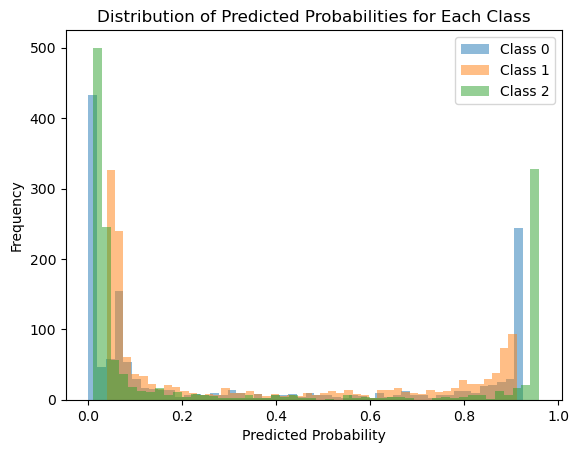

In [26]:
import matplotlib.pyplot as plt

for i in range(probabilities.shape[1]):  # For each class
    plt.hist(probabilities[:, i], bins=50, alpha=0.5, label=f'Class {i}')
plt.title('Distribution of Predicted Probabilities for Each Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [27]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!B11:E11'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


# Validate on Data C

## Load Data C Dataset

In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load validation data
validation_file_path = 'Corpus/FiReCS/FiReCS_data_c.csv'
validation_df = pd.read_csv(validation_file_path)

## Perform Blending

In [29]:
%%memit

# Generate meta-features for validation set
validation_meta_features = [get_meta_features(model, tokenizer, validation_df, device) 
                            for model, tokenizer in models_and_tokenizers.values()]

# Stack meta-features
validation_meta_features = np.hstack(validation_meta_features)

# Predict with LR meta-classifier
lr_validation_predictions = lr_meta_classifier.predict(validation_meta_features)

# Predict with NB meta-classifier
nb_validation_predictions = nb_meta_classifier.predict(validation_meta_features)

# Predict with DT meta-classifier
dt_validation_predictions = dt_meta_classifier.predict(validation_meta_features)

# Predict with SVM meta-classifier
svm_validation_predictions = svm_meta_classifier.predict(validation_meta_features)

# Extract true labels from the validation set
true_labels = validation_df['label'].values

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2493.44 MiB, increment: 92.08 MiB


## Validate Models

### LR

In [30]:
# Calculate metrics
accuracy = accuracy_score(true_labels, lr_validation_predictions)
precision = precision_score(true_labels, lr_validation_predictions, average='macro')
recall = recall_score(true_labels, lr_validation_predictions, average='macro')
f1 = f1_score(true_labels, lr_validation_predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, lr_validation_predictions)

# Print the metrics
print("Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Logistic Regression
Accuracy: 0.8008
Precision: 0.8040
Recall: 0.8021
F1 Score: 0.8029
Confusion Matrix:
 [[278  61   2]
 [ 55 268  41]
 [  4  46 294]]


#### Optimized LR

In [31]:
lr_validation_probabilities = lr_meta_classifier.predict_proba(validation_meta_features)

# Apply thresholds to the validation set probabilities to make final predictions
lr_validation_predictions = np.array([np.argmax([lr_validation_probabilities[i, j] if lr_validation_probabilities[i, j] >= lr_thresh[j] else 0
                                              for j in range(lr_validation_probabilities.shape[1])])
                                   for i in range(len(lr_validation_probabilities))])

# Evaluate threshold on validation set
adjusted_precision = precision_score(true_labels, lr_validation_predictions, average='macro')
adjusted_recall = recall_score(true_labels, lr_validation_predictions, average='macro')
adjusted_accuracy = accuracy_score(true_labels, lr_validation_predictions)
adjusted_f1 = f1_score(true_labels, lr_validation_predictions, average='macro')
adjusted_conf_matrix = confusion_matrix(true_labels, lr_validation_predictions)

# Print the evaluation results
print("Validation Results")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)


Validation Results
Precision: 0.8040
Recall: 0.8021
Accuracy: 0.8008
F1 Score: 0.8029
Confusion Matrix:
[[278  61   2]
 [ 55 268  41]
 [  4  46 294]]


In [32]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!F8:I8'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [33]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, lr_validation_predictions)

# Define class names
class_names = ['Negative', 'Neutral', 'Positive']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OF_Using_FIRE 3B-2 LR'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [34]:

# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, '3B-2 LR.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/3B-2 LR.png


### NB

In [35]:
# Calculate metrics
accuracy = accuracy_score(true_labels, nb_validation_predictions)
precision = precision_score(true_labels, nb_validation_predictions, average='macro')
recall = recall_score(true_labels, nb_validation_predictions, average='macro')
f1 = f1_score(true_labels, nb_validation_predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, nb_validation_predictions)

# Print the metrics
print("Naive Bayes")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Naive Bayes
Accuracy: 0.7950
Precision: 0.7982
Recall: 0.7964
F1 Score: 0.7972
Confusion Matrix:
 [[275  64   2]
 [ 58 264  42]
 [  3  46 295]]


#### Optimized NB

In [36]:
nb_validation_probabilities = nb_meta_classifier.predict_proba(validation_meta_features)

# Apply thresholds to the validation set probabilities to make final predictions
nb_validation_predictions = np.array([np.argmax([nb_validation_probabilities[i, j] if nb_validation_probabilities[i, j] >= nb_thresh[j] else 0
                                              for j in range(nb_validation_probabilities.shape[1])])
                                   for i in range(len(nb_validation_probabilities))])

# Evaluate threshold on validation set
adjusted_precision = precision_score(true_labels, nb_validation_predictions, average='macro')
adjusted_recall = recall_score(true_labels, nb_validation_predictions, average='macro')
adjusted_accuracy = accuracy_score(true_labels, nb_validation_predictions)
adjusted_f1 = f1_score(true_labels, nb_validation_predictions, average='macro')
adjusted_conf_matrix = confusion_matrix(true_labels, nb_validation_predictions)

# Print the evaluation results
print("Validation Results")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)


Validation Results
Precision: 0.8013
Recall: 0.7971
Accuracy: 0.7960
F1 Score: 0.7988
Confusion Matrix:
[[275  64   2]
 [ 58 270  36]
 [  3  51 290]]


In [37]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!F9:I9'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [38]:
import altair as alt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, nb_validation_predictions)

# Define class names
class_names = ['Negative', 'Neutral', 'Positive']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OF_Using_FIRE 3B-2 NB'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [39]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OF_Using_FIRE 3B-2 NB.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/OF_Using_FIRE 3B-2 NB.png


### DT

In [40]:
# Calculate metrics
accuracy = accuracy_score(true_labels, dt_validation_predictions)
precision = precision_score(true_labels, dt_validation_predictions, average='macro')
recall = recall_score(true_labels, dt_validation_predictions, average='macro')
f1 = f1_score(true_labels, dt_validation_predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, dt_validation_predictions)

# Print the metrics
print("Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Decision Tree
Accuracy: 0.7607
Precision: 0.7612
Recall: 0.7625
F1 Score: 0.7618
Confusion Matrix:
 [[261  71   9]
 [ 67 243  54]
 [  6  44 294]]


#### Optimized DT

In [41]:
dt_validation_probabilities = dt_meta_classifier.predict_proba(validation_meta_features)

# Apply thresholds to the validation set probabilities to make final predictions
dt_validation_predictions = np.array([np.argmax([dt_validation_probabilities[i, j] if dt_validation_probabilities[i, j] >= dt_thresh[j] else 0
                                              for j in range(dt_validation_probabilities.shape[1])])
                                   for i in range(len(dt_validation_probabilities))])

# Evaluate threshold on validation set
adjusted_precision = precision_score(true_labels, dt_validation_predictions, average='macro')
adjusted_recall = recall_score(true_labels, dt_validation_predictions, average='macro')
adjusted_accuracy = accuracy_score(true_labels, dt_validation_predictions)
adjusted_f1 = f1_score(true_labels, dt_validation_predictions, average='macro')
adjusted_conf_matrix = confusion_matrix(true_labels, dt_validation_predictions)

# Print the evaluation results
print("Validation Results")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)


Validation Results
Precision: 0.7612
Recall: 0.7625
Accuracy: 0.7607
F1 Score: 0.7618
Confusion Matrix:
[[261  71   9]
 [ 67 243  54]
 [  6  44 294]]


In [42]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!F10:I10'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [43]:
import altair as alt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, dt_validation_predictions)

# Define class names
class_names = ['Negative', 'Neutral', 'Positive']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OF_Using_FIRE 3B-2 DT'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [44]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OF_Using_FIRE 3B-2 DT.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/OF_Using_FIRE 3B-2 DT.png


### SVM

In [45]:
# Calculate metrics
accuracy = accuracy_score(true_labels, svm_validation_predictions)
precision = precision_score(true_labels, svm_validation_predictions, average='macro')
recall = recall_score(true_labels, svm_validation_predictions, average='macro')
f1 = f1_score(true_labels, svm_validation_predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, svm_validation_predictions)

# Print the metrics
print("SVM")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

SVM
Accuracy: 0.8074
Precision: 0.8122
Recall: 0.8084
F1 Score: 0.8100
Confusion Matrix:
 [[278  60   3]
 [ 55 276  33]
 [  3  48 293]]


#### Optimized SVM

In [46]:
svm_validation_probabilities = svm_meta_classifier.predict_proba(validation_meta_features)

# Apply thresholds to the validation set probabilities to make final predictions
svm_validation_predictions = np.array([np.argmax([svm_validation_probabilities[i, j] if svm_validation_probabilities[i, j] >= svm_thresh[j] else 0
                                              for j in range(svm_validation_probabilities.shape[1])])
                                   for i in range(len(svm_validation_probabilities))])

# Evaluate threshold on validation set
adjusted_precision = precision_score(true_labels, svm_validation_predictions, average='macro')
adjusted_recall = recall_score(true_labels, svm_validation_predictions, average='macro')
adjusted_accuracy = accuracy_score(true_labels, svm_validation_predictions)
adjusted_f1 = f1_score(true_labels, svm_validation_predictions, average='macro')
adjusted_conf_matrix = confusion_matrix(true_labels, svm_validation_predictions)

# Print the evaluation results
print("Validation Results")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)


Validation Results
Precision: 0.8090
Recall: 0.8056
Accuracy: 0.8046
F1 Score: 0.8070
Confusion Matrix:
[[276  62   3]
 [ 53 274  37]
 [  3  47 294]]


In [47]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '3-2!F11:I11'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [48]:
import altair as alt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, svm_validation_predictions)

# Define class names
class_names = ['Negative', 'Neutral', 'Positive']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OF_Using_FIRE 3B-2 SVM'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [49]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OF_Using_FIRE 3B-2 SVM.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On FireCS dataset/OF Using FIRE ENSEMBLE/Blending/OF_Using_FIRE 3B-2 SVM.png
